Le but de ce TP est la modélisation et l'analyse statistique de diverses données dues à la crise sanitaire actuelle dûe au COVID-19.


Préambule: 
Devant le sérieux de la situation, il est important de faire au mieux un panorama de ce que l'on comprend et de ce que l'on ne comprend pas. Ce sujet n'a absolument pas pour objectif de vous faire arriver à une conclusion - mais plutôt de comprendre à quel point la situation est complexe et que les conclusions sont très incertaines.

Les fichiers de données à télécharger sont:
- [Les nombres de cas et le nombre de tests effectués par pays](https://www.math.univ-toulouse.fr/~rchhaibi/teaching/2019/M1SID/tests-vs-confirmed-cases-covid-19.csv)
- [Séries temporelles des cas confirmés](https://www.math.univ-toulouse.fr/~rchhaibi/teaching/2019/M1SID/time_series_covid19_confirmed_global.csv)
- [Séries temporelles de décès](https://www.math.univ-toulouse.fr/~rchhaibi/teaching/2019/M1SID/time_series_covid19_deaths_global.csv)

## I. COVID-19: Analyse bivariée du nombre de tests vs nombre de cas confirmés

In [8]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Importation des données et nettoyage
dataframe=pd.read_csv("tests-vs-confirmed-cases-covid-19.csv")
print(dataframe.head())

        Entity Code          Date  Total COVID-19 tests  \
0  Afghanistan  AFG  Dec 31, 2019                   NaN   
1  Afghanistan  AFG   Jan 1, 2020                   NaN   
2  Afghanistan  AFG   Jan 2, 2020                   NaN   
3  Afghanistan  AFG   Jan 3, 2020                   NaN   
4  Afghanistan  AFG   Jan 4, 2020                   NaN   

   Total confirmed cases of COVID-19 (cases)  
0                                        0.0  
1                                        0.0  
2                                        0.0  
3                                        0.0  
4                                        0.0  


In [10]:
#Compiling totals
print("Compiling totals...")
total_tests = {}
total_cases = {}
for i in range( len(dataframe) ):
    row    = dataframe.iloc[[i]].as_matrix()[0]
    entity = row[0]
    if not entity in total_tests:
        total_tests[entity] = 0
    if not entity in total_cases:
        total_cases[entity] = 0
    tests  = row[-2]
    cases  = row[-1]
    total_tests[entity] = max(total_tests[entity], tests)
    total_cases[entity] = max(total_cases[entity], cases)
print("Done.")
print("")

#Delete keys with either zero test or zero case
print("Cleaning zeroes...")
null_keys = [ key for key in total_tests.keys() if (total_tests[key]==0) or (total_cases[key]==0)]
print("List of countries with zero test or zero case")
print(null_keys)
for key in null_keys:
    del total_tests[key]
    del total_cases[key]

Compiling totals...
Done.

Cleaning zeroes...
List of countries with zero test or zero case
['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Aruba', 'Australia - Australian Capital Territory', 'Australia - New South Wales', 'Australia - Queensland', 'Australia - South Australia', 'Australia - Tasmania', 'Australia - Victoria', 'Australia - Western Australia', 'Azerbaijan', 'Bahamas', 'Bangladesh', 'Barbados', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada', 'Canada - Alberta', 'Canada - British Columbia', 'Canada - National lab', 'Canada - New Brunswick', 'Canada - Northwest Territories', 'Canada - Nova Scotia', 'Canada - Ontario', 'Canada - Quebec', 'Canada - Saskatchewan', 'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'China - Guangdong', 'Congo', "Cote d'Ivoire", 'Cuba', 'Curacao', 'Cyprus', 'Democr

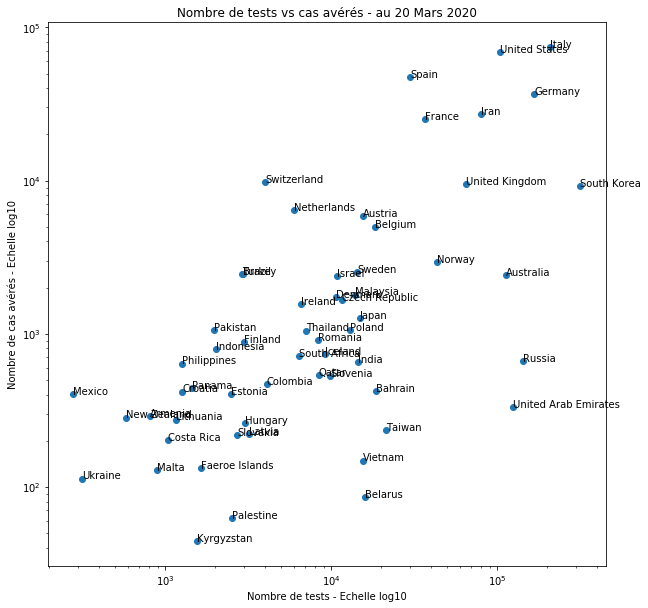

In [88]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 10, 10
labels      = np.array( list(total_tests.keys())   )
array_tests = np.array( list(total_tests.values()) )
array_cases = np.array( list(total_cases.values()) )

fig, ax = plt.subplots()
ax.scatter( array_tests, array_cases )
for i in range(len(labels)):
    ax.annotate( labels[i], (array_tests[i], array_cases[i]) )
plt.xlabel('Nombre de tests - Echelle log10')
plt.ylabel('Nombre de cas avérés - Echelle log10')
plt.title ('Nombre de tests vs cas avérés - au 20 Mars 2020' )
plt.xscale('log')
plt.yscale('log')
plt.show()

### Ex 1: Régression linéaire

Les variables d'intérêt sont le nombre de cas avérés, et les variables explicatives sont le nombre de tests effectués.

On considère le modèle de regression simple
$$ Y_i = X_i \theta + \varepsilon_i \ ,$$
où $i=1, 2, \dots, n$. Ici chaque indice $i$ représente un pays et il y a $n$ pays. Les variables de bruit $\varepsilon_i$ sont iid normales centrées de variance $\sigma^2$.

On réécrit le tout matriciellement sous la forme
$$ \mathbb{Y} = \mathbb{X} \Theta + \varepsilon \ ,$$
avec
- $\mathbb{Y} \in \mathbb{R}^n \approx M_{n,1}(\mathbb{R})$
- $\Theta \in \mathbb{R}^k \approx M_{k,1}(\mathbb{R})$
- $\mathbb{X} \in M_{n,k}(\mathbb{R})$
- $\varepsilon \in \mathbb{R}^n$ 

Maintenant:

1. Effectuer la régression linéaire par OLS, et calculer le coefficient de détermination R2. On écrira son propre code avec la formule donnée en cours.

2. Reprenez le plot précédent et tracez la droite de régression.

3. Faire de même avec le package statsmodels avec cette fois-ci les intervalles de confiance pour $\theta$. On regardera en particulier sur [le lien suivant](https://www.statsmodels.org/dev/regression.html).

In [37]:
# OLS
def OLS_estim(X,Y) :
    res = np.dot(X.transpose(),X)
    res = np.linalg.inv(res)
    res = res.dot(X.transpose())
    theta = res.dot(Y)
    return theta

def coef_R2(y,y_est) : 
    N1 = np.linalg.norm(y_est -np.mean(y_est))
    N2 = np.linalg.norm(y-np.mean(y))
    return (N1/N2)**2

Y = array_cases
const = np.ones(Y.shape)
X = np.stack([const,array_tests],axis=1) 


theta = OLS_estim(X,Y)
Y_est = X.dot(theta)
R2 = coef_R2(Y,Y_est)


print('theta :', theta)
print("R2 :", R2)


theta : [2.17424722e+03 1.36224395e-01]
R2 : 0.27182090005879533


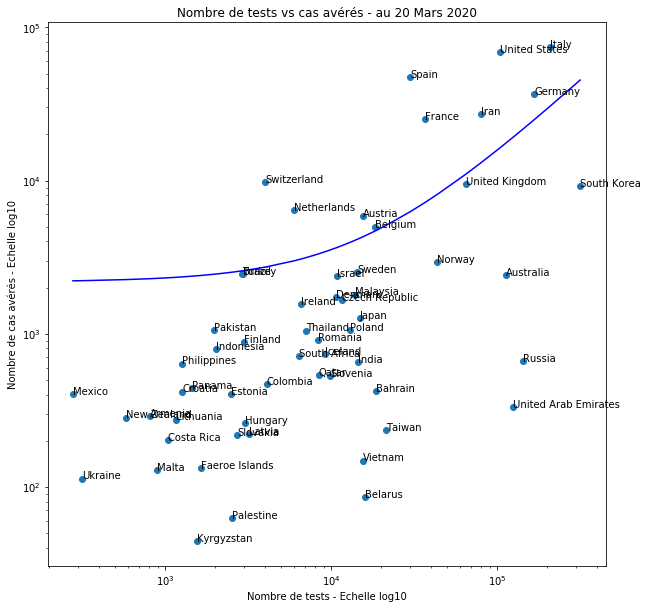

In [38]:
#Même plot avec la droite de la regression sur une échelle log log :
plt.rcParams['figure.figsize'] = 10, 10
labels      = np.array( list(total_tests.keys())   )
array_tests = np.array( list(total_tests.values()) )
array_cases = np.array( list(total_cases.values()) )

fig, ax = plt.subplots()
ax.scatter( array_tests, array_cases )
ind = np.argsort(array_tests)
plt.plot(array_tests[ind], Y_est[ind],'b-')
for i in range(len(labels)):
    ax.annotate( labels[i], (array_tests[i], array_cases[i]) )
plt.xlabel('Nombre de tests - Echelle log10')
plt.ylabel('Nombre de cas avérés - Echelle log10')
plt.title ('Nombre de tests vs cas avérés - au 20 Mars 2020' )
plt.xscale('log')
plt.yscale('log')
plt.show()

In [41]:
#STATSMODELS
import statsmodels.api as sm

mod = sm.OLS(Y,X)

res = mod.fit()

print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     20.90
Date:                Sat, 09 May 2020   Prob (F-statistic):           2.71e-05
Time:                        00:10:34   Log-Likelihood:                -631.64
No. Observations:                  58   AIC:                             1267.
Df Residuals:                      56   BIC:                             1271.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2174.2472   1954.194      1.113      0.2

les résultats s'accordent. Les intervals de confiance sont (-1740.475  ,  6088.969) et (0.077   ,    0.196) resp. pour la pente et l'ordonnée à l'origine. 

### Ex 2: Commentaires

1. Au sujet du plot "Nombre de cas vs nombre de cas avérés", pourquoi considérer les données une échelle logarithmique alors que nous ne l'avons pas fait sur la régression?

2. Si nous écrivons le modèle linéaire comme
$$ Y = \alpha + \beta X \ ,$$
commenter les intervalles de confiances pour $\widehat{\alpha}$ et $\widehat{\beta}$.

3. Proposer un modèle réduit et compléter la phrase suivante "Pour 100 tests, nous décelons en moyenne ___ cas supplémentaires".

4. Il y a une corrélation positive visible entre nombre de cas et nombre cas testés. Au dela de la remarque évidente que "plus on est de gens, plus on trouve de cas", il existe beaucoup de disparités entre pays. Quelles différences pensez-vous trouver en décomposant l'échantillon en deux:
  * les pays qui ont une politique de tests systématique vs ceux qui n'en ont pas.
  * les pays où la pandémie est très répandue vs les pays où elle ne l'est pas encore.

et en refaisant une régression pour chaque sous-groupe.

Réponses : 
1. Parce les valeurs varient largements (il y a des pays avec 2 ou 3 cas/test et d'autres avec des milliers de cas/tests). Donc on utilise une échelle log log pour bien voir l'étendu du nuage de tout les points dans la même figure. 
2. Les intervals de confiance sont (-1740.475 , 6088.969) et (0.077 , 0.196) resp. pour $\widehat{\alpha}$ et $\widehat{\beta}$ . les intervalles de confiance sont assez grands.

3. Pour 100 tests, nous décelons en moyenne 100*$\beta$ =13.6224395 cas supplémentaires. Avec $\beta$ = 1.36224395e-01 (et $\alpha$ = 2.17424722e+03) .

4. j'attend une meilleur correlation pour les pays qui ont une politique de tests systématique que pour ceux qui n'en ont pas. Plus on test moins il y a des fluctuations dans le nombre de cas dûs à l'incertitude de l'estimation de leur nombre. j'attends aussi que la correlation soit meilleur dans les pays ou il y a peut de cas que pour les pays ou la pandémie est répondue. Car on peut facilement tester quelques cas.  

In [140]:
#4. Verifions cela  :
# premier cas : étude des pays qui ont une politique de tests systématique vs ceux qui n'en ont pas.

seuila = np.mean(array_tests) #on utilise la moyenne des tests pour séparer l'échantillon
Xa1 = array_tests[ array_tests < seuila ]
Xa1 = sm.add_constant(Xa1, prepend=False)
Ya1 = array_cases[ array_tests < seuila ]
Xa2 = array_tests[ array_tests > seuila ] 
Xa2 = sm.add_constant(Xa2, prepend=False)
Ya2 = array_cases[ array_tests > seuila ] 

mod1a = sm.OLS(Ya1,Xa1)
mod2a = sm.OLS(Ya2,Xa2)

resa1 = mod1a.fit()
resa2 = mod2a.fit()
# deuxième cas : étude des pays où la pandémie est très répandue vs les pays où elle ne l'est pas encore.

seuilb = np.mean(array_cases) #on utilise la moyenne des cas pour séparer l'échantillon
Xb1 = array_tests[ array_cases < seuilb ]
Xb1 = sm.add_constant(Xb1, prepend=False)
Yb1 = array_cases[ array_cases < seuilb ]
Xb2 = array_tests[ array_cases > seuilb ]
Xb2 = sm.add_constant(Xb2, prepend=False)
Yb2 = array_cases[ array_cases > seuilb ] 

mod1b = sm.OLS(Yb1,Xb1)
mod2b = sm.OLS(Yb2,Xb2)

resb1 = mod1b.fit()
resb2 = mod2b.fit()

print(resa1.summary())
print(resa2.summary())
print(resb1.summary())
print(resb2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     16.53
Date:                Sun, 10 May 2020   Prob (F-statistic):           0.000190
Time:                        22:43:56   Log-Likelihood:                -475.05
No. Observations:                  47   AIC:                             954.1
Df Residuals:                      45   BIC:                             957.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5277      0.130      4.066      0.0

## II. Séries temporelles

Le but de cette section est uniquement de vous donner une idée de la progression des choses en affichant des séries temporelles.

On selectionne les pays ayant plus de 100 décès pour que l'information soit significative et cela est stocké dans les variables $X$ et $Y$.

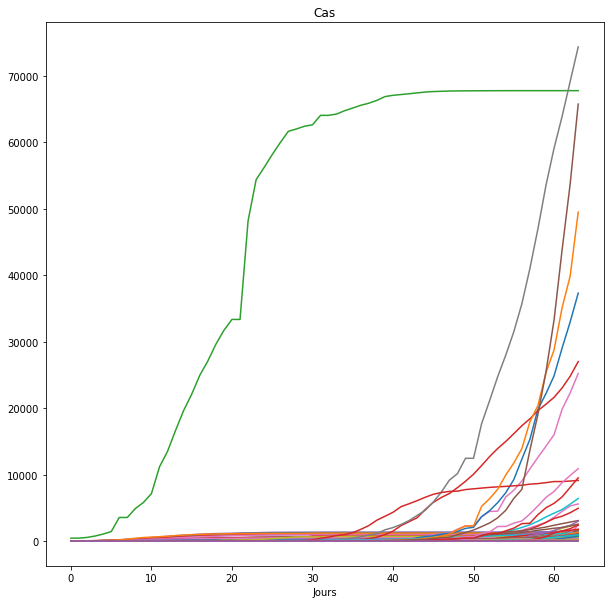

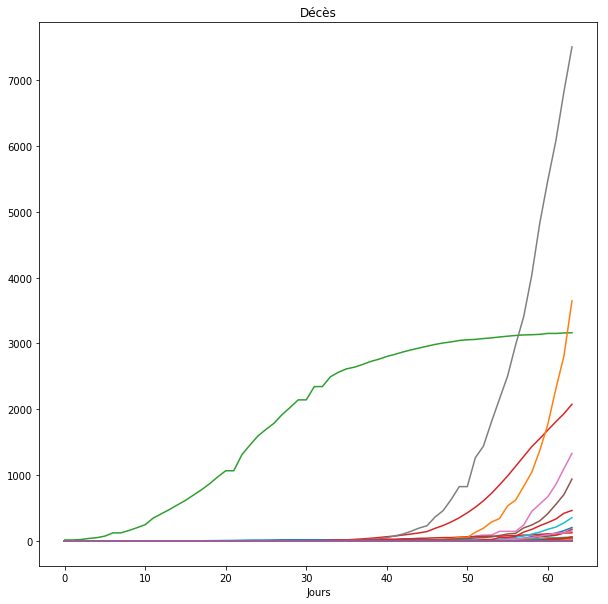

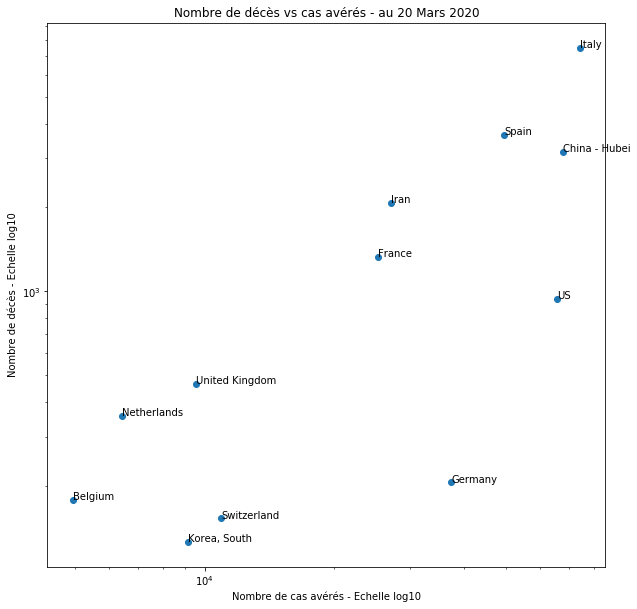

In [89]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import data and cleaning
df_cases  = pd.read_csv("time_series_covid19_confirmed_global.csv")
df_cases  = df_cases.drop(['Lat', 'Long'], axis=1)
df_cases.head()
df_deaths = pd.read_csv("time_series_covid19_deaths_global.csv")
df_deaths = df_deaths.drop(['Lat', 'Long'], axis=1)
df_deaths.head()

def aggregate_to_dict(df):
    dict = {}
    for i in range( len(df) ):
        row = df.iloc[[i]].as_matrix()[0]
        if row[0]!=row[0]: # Test nan
            key = row[1]
        else:
            key = row[1] + " - " + str(row[0])
        #
        dict[key] = row[2:]
    # end for
    return dict

#Convert to dictionaries
dict_cases  = aggregate_to_dict(df_cases)
dict_deaths = aggregate_to_dict(df_deaths)
assert( dict_cases.keys() == dict_deaths.keys() )

#Plots of time series
for x in dict_cases:
    plt.plot(dict_cases[x])
plt.title("Cas")
plt.xlabel("Jours")
plt.show()
for x in dict_cases:
    plt.plot(dict_deaths[x])
plt.title("Décès")
plt.xlabel("Jours")
plt.show()

#Bivariate plot of most recent values final values
labels             = np.array( [ key for key in dict_cases ] )
most_recent_cases  = np.array( [ dict_cases[key] [-1] for key in dict_cases]  )
most_recent_deaths = np.array( [ dict_deaths[key][-1] for key in dict_deaths] )
non_zero_values    = np.where( most_recent_deaths>100 )[0] # Cut data below 100
labels             = labels[non_zero_values]
most_recent_cases  = most_recent_cases [non_zero_values]
most_recent_deaths = most_recent_deaths[non_zero_values]
fix, ax = plt.subplots()
ax.scatter( most_recent_cases, most_recent_deaths )
for i in range(len(labels)):
    ax.annotate( labels[i], (most_recent_cases[i], most_recent_deaths[i]) )
plt.xlabel('Nombre de cas avérés - Echelle log10')
plt.ylabel('Nombre de décès - Echelle log10')
plt.title ('Nombre de décès vs cas avérés - au 20 Mars 2020' )
plt.xscale('log')
plt.yscale('log')
plt.show()

#Used in the next section
Y = most_recent_deaths
X = np.log10( most_recent_cases )
intercept = np.ones(Y.shape)
X = np.stack( [intercept, X], axis=1 ) # Add intercept

## III. Implémentation du modèle log-linéaire / Poisson

Nous nous intéressons à l'estimation de la dépendance entre le nombre de décès $Y_i$ et le (logarithme du) nombre de cas recensés comme variables explicatives. Ainsi les variables explicatives sont les $X_i \in \mathbb{R}^2$. Une dimension de plus est obtenue en ajoutant l'intercept. 

Théoriquement, ceci permettrait d'estimer la mortalité du COVID-19. Toutefois le nombre de cas recensés sous-estime grandement le nombre de véritables cas - parfois par un facteur $5$ à $10$ dans les pays ne pratiquant pas de dépistage systématique. Ainsi, il faut avoir à l'esprit que dans les estimations suivantes, la mortalité du COVID-19 est fortement exagérée. La méthodologie reste la même dans le cas de données plus précises. 

Par la loi des évennements rares, la loi naturelle pour $Y$ est la loi de Poisson:
$$ \forall k \in \mathbb{N}, \ \mathbb{P}\left( Y=k \right) = e^{-\lambda} \frac{\lambda^k}{k!} \ ,$$
où $\lambda>0$ est le paramètre. Mais conformément à la logique du modèle linéaire généralisé, la régression de Poisson suppose que la paramètre $\lambda$ est lié à la variable explicative $X$. On pourra se référer à la [page Wikipedia](https://en.wikipedia.org/wiki/Poisson_regression).

- La fonction de lien est le logarithme 
$$ \log \lambda = \beta X$$
où $\beta X$ est le produit scalaire entre les paramètres $\beta \in \mathbb{R}^2$ et les facteurs $X \in \mathbb{R}^2$. D'où les noms de "Modèle log-linéaire" / "Modèle de regression Poisson". In fine, la loi conditionnelle est:
$$ \forall k \in \mathbb{N}, \ \mathbb{P}\left( Y=k | X \right) = e^{-e^{\beta X}} \frac{e^{k \beta X}}{k!} \ .$$

- Dans ce cas, la log-vraisemblance s'écrit
$$
   \ell\left( y, x, \beta \right)
 = \frac{1}{n} \sum_{i=1}^n \left[ y_i (\beta x_i) - e^{\beta x_i} - \log y_i! \right]
$$
Preuve:
$$
   \begin{align*}
   \ell\left( y, x, \beta \right) := & \frac{1}{n} \log \mathbb{P}\left( \forall i, \ Y_i = y_i | \forall i, \ X_i = x_i \right) \\
   = & \frac{1}{n} \sum_{i=1}^n \log \mathbb{P}\left( Y_i = y_i | X_i = x_i \right) \\
   = & \frac{1}{n} \sum_{i=1}^n \log e^{-e^{\beta x_i}} \frac{e^{y_i \beta x_i}}{y_i!}
   \\
   = & \frac{1}{n} \sum_{i=1}^n \left[ y_i (\beta x_i) - e^{\beta x_i} - \log y_i! \right]
   & \qquad \qquad \qquad \qquad \qquad \qquad CQFD
   \end{align*}
$$
- En conséquence:
$$
   \nabla_\beta \ell\left( y, x, \beta \right)
 = \frac{1}{n} \sum_{i=1}^n \left(
   y_i
   -
   e^{\beta x_i}
   \right) x_i
 = \frac{1}{n} V X \ ,
$$
$$
   \nabla_\beta^2 \ell\left( y, x, \beta \right)
 = -\frac{1}{n} \sum_{i=1}^n 
   e^{\beta x_i}
   x_i^T x_i 
 = \ \frac{1}{n} X^T W X,
$$
où $V$ et $W$ sont les matrices explicites:
$$ V = \left( y_i - e^{\beta x_i} \right)_{i} \in M_{1,n}(\mathbb{R}) ,$$
$$ W = \textrm{diag}\left( -e^{\beta x_i} \right)_{1 \leq i \leq n} \ .$$
La matrice $X \in M_{n,2}(\mathbb{R})$ est la matrice dont les lignes sont les facteurs explicatifs.

- Dans la maximisation de la vraisemblance, expliquer pourquoi nous avons le droit de poser:
$$
   \ell\left( y, x, \beta \right)
 = \frac{1}{n} \sum_{i=1}^n \left[ y_i (\beta x_i) - e^{\beta x_i} \right]
$$
et que les expressions des dérivées nécessaires à l'optimisation restent inchangées.

### Exercice 3:
Refaire les calculs ci-dessus et écrire trois fonctions
- ${\it logL}$: Calcul de la log vraisemblance
- ${\it diff\_logL}$ : Calcul de son gradient
- ${\it diff2\_logL}$: Calcul de la matrice Hessienne

Réponse : le $\log y_i!$ est indépendant de $\beta$, donc on peut s'en passer pour la calcul du maximum de vraisemblance puisqu'il va s'annuler aussitot qu'on différencie par rapport à $\beta$. 

In [116]:
vect_log_fact = lambda V : np.array([np.sum(np.log(np.arange(1,V[i]+1))) for i in range(len(V))])

def logL( beta, y, x):
    res = 0 
    betax = np.dot(x,beta)
    res  = np.sum(y*betax -np.exp(betax)) #-vect_log_fact(y))
    res = res/len(y)
    return res

def diff_logL( beta, y, x):
    res = 0 
    betax = np.dot(x,beta)
    v= y - np.exp(betax)
    res = v.dot(x)
    res = res/len(y)
    return res

def diff2_logL( beta, y, x):
    res = 0 
    betax = np.dot(x,beta)
    w = -np.exp(betax)
    w = np.diag(w)
    res = np.dot(x.transpose(),w.dot(x))
    res = res/len(y)
    return res

In [131]:
# Test
k     = X.shape[1]
beta0 = np.random.rand(k)/np.max(X)
print("Log-vraisemblance initiale: ", logL(beta0, Y, X))
print("Gradient  initial : ", diff_logL(beta0, Y, X))
print("Hessienne initiale: ", diff2_logL(beta0, Y, X) )

Log-vraisemblance initiale:  913.8979110713439
Gradient  initial :  [1677.24026365 7865.81868116]
Hessienne initiale:  [[ -1.67640302  -7.30179806]
 [ -7.30179806 -32.08333259]]


### Ex 4:
- Pourquoi avons-nous pris $X$ étant le logarithme des nombres de décès?
Indication: Penser à la relation
$$ \log \lambda = \beta X \ .$$
- Donner l'estimateur de maximum de vraisemblance $\widehat{\beta}$ et commenter. Pour cela on écrira un algorithme de Newton-Raphson comme vu en cours et en TP (délicat pour la régression Poisson), ou bien un algorithme de descente de gradient.
- Utiliser statsmodels pour faire la régression Poisson en regardant [ici](https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Poisson.html)

Sous l'hypothèse de la distribution poisson, Lambda est le nombre moyen de décès dans un intervalle de temps fixé. On peut voir que ce nombre moyen augmente rapidement avec le nombre de cas en regardant la surfaces sous les trajectoires des deux premières figures dans la section précédente. Ces trajectoire ayant une croissance de fonctions puissance, il est légitime de vouloir exprimer lambda en une puissance du nombre de décès d'où la regression puissance qui se réduit à une regression linaire en le log des variables (ici x ne prend pas des valeurs nulles). d'où la formule au dessus.

In [156]:
def newton_raphson( x0, func, jacobian_func, n_max=100, eps=1e-5, optional=None):
    x = x0 
    for k in range(n_max+1) :
        jac = jacobian_func(x)
        jac_inv = np.linalg.inv(jac)
        x = x - np.dot(jac_inv,func(x)) # En fait, dans une régression de Poisson, le pas peut exploser. A modérer si besoin.
        if np.linalg.norm(func(x))<eps :
            break 
    return (x, k)

# l'ajustement du model
k     = X.shape[1]
#Newton-Raphson est sensible aux valeurs initiales, j'ai dû fait un choix éduqué (par la méthode des moyennes)
beta0 = np.zeros(k)+(np.log(np.mean(Y))/np.mean(X)) 
l     = lambda beta : logL(beta, Y, X)
diff  = lambda beta : diff_logL(beta, Y, X) 
diff2 = lambda beta : diff2_logL(beta, Y, X) 
result = newton_raphson( beta0, diff, diff2) 
print("")

print(f" Le log de vraisemblance : {l(result[0])} \n Le nombre d'iterations: {result[1]}  \n Beta estimée: {result[0]}")


 Le log de vraisemblance : 11506.699813704492 
 Le nombre d'iterations: 11  
 Beta estimée: [-5.90007487  2.93293499]


In [115]:
from statsmodels.discrete.discrete_model import Poisson

model  = Poisson(Y,X)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 367.793195
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                   12
Model:                        Poisson   Df Residuals:                       10
Method:                           MLE   Df Model:                            1
Date:                Sun, 10 May 2020   Pseudo R-squ.:                  0.6613
Time:                        21:38:08   Log-Likelihood:                -4413.5
converged:                       True   LL-Null:                       -13031.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.9001      0.132    -44.539      0.000      -6.160      -5.640
x1             2.9329      0.028    103.971      0.000       2.878       2.988
==============================================================================
"""

Les résultats s'accordent.